In [1]:
%load_ext blackcellmagic

In [2]:
import os, pdb
import pandas as pd
import seaborn as sns
from train_model import enrich_data_with_movies_features, prepare_data_for_sklearn, train_model, compare_methods

/home/rohail/.conda/envs/imdb/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# from typing import Tuple, Dict, List, Optional, Union, Set
# from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
# from yellowbrick.classifier import DiscriminationThreshold
# from yellowbrick.regressor import ResidualsPlot
# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score
# import time, datetime
# import numpy as np
# import joblib
# import warnings
# %matplotlib inline

# Parameters

In [4]:
TARGET_CUTOFF = 7.5
PROJECT_BASE_DIR = "/home/rohail/projects/imdb_ratings/"
model_save_dir = "models/"
data_dir = "data/raw/"
plot_write_dir = "reports/figures"
idx_columns = ["imdb_title_id", "title", "original_title"]

In [5]:
main_fname = "movies.csv"
df = pd.read_csv(os.path.join(PROJECT_BASE_DIR, data_dir, main_fname))
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


# Enrich data with features from movie dataset

In [6]:
df_subset = enrich_data_with_movies_features(df, idx_columns, target_columns = ["avg_vote"], dummy = False)
# remove rows where we are missing user/critic reviews
missing_user_critic_review_mask = (
    df[["reviews_from_users", "reviews_from_critics"]].isna().any("columns")
)
df_subset = df_subset.loc[~missing_user_critic_review_mask].copy()
df_subset.head()

,imdb_title_id,title,original_title,year,duration,reviews_from_users,reviews_from_critics,primary_country,primary_language,primary_genre,global,vote_popularity,avg_vote
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,7.0,7.0,Australia,not_available,Biography,False,mid_high_q75,6.1
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,53,4.0,2.0,Germany,not_available,Drama,True,low_q25,5.9
2,tt0002101,Cleopatra,Cleopatra,1912,100,24.0,3.0,USA,English,Drama,False,low_mid_q50,5.2
3,tt0002130,L'Inferno,L'Inferno,1911,68,28.0,14.0,Italy,Italian,Adventure,False,high_q99,7.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,60,12.0,5.0,USA,English,Biography,False,low_mid_q50,5.7


# Scaling data/dummy encoding, etc

In [7]:
df_model, _ = prepare_data_for_sklearn(
    df_subset, dummy_encoding=True, target_variable="avg_vote", idx_columns=idx_columns
)
df_model.head()

,year,duration,reviews_from_users,reviews_from_critics,global,primary_country_Albania,primary_country_Algeria,primary_country_Angola,primary_country_Argentina,primary_country_Armenia,...,primary_genre_Thriller,primary_genre_War,primary_genre_Western,vote_popularity_low_mid_q50,vote_popularity_low_q25,vote_popularity_mid_high_q75,avg_vote,imdb_title_id,title,original_title
0,-3.503253,-1.362888,-0.245557,-0.371781,-0.971666,0,0,0,0,0,...,0,0,0,0,0,1,6.1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang
1,-3.300321,-2.133698,-0.263384,-0.455023,1.029161,0,0,0,0,0,...,0,0,0,0,1,0,5.9,tt0001892,Den sorte drøm,Den sorte drøm
2,-3.259735,-0.002634,-0.144539,-0.438375,-0.971666,0,0,0,0,0,...,0,0,0,1,0,0,5.2,tt0002101,Cleopatra,Cleopatra
3,-3.300321,-1.453571,-0.120770,-0.255241,-0.971666,0,0,0,0,0,...,0,0,0,0,0,0,7.0,tt0002130,L'Inferno,L'Inferno
4,-3.259735,-1.816306,-0.215846,-0.405078,-0.971666,0,0,0,0,0,...,0,0,0,1,0,0,5.7,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz..."


# Binarize the target

In [8]:
df_model.loc[:, "avg_vote_flag"] = (df_model.avg_vote >= TARGET_CUTOFF).astype(int)
class_balance = df_model.avg_vote_flag.value_counts()
percentage_of_total = float(
    (class_balance[class_balance.index == 1]) / class_balance.sum()
)
percent = "{:.2%}".format(percentage_of_total)

if class_balance.loc[1] < 5:
    print("Not fitting model due to lack of positive samples.")

print(
    f"The positive class represents {percent} of the total instances.\n"
    f"Positives: {class_balance.loc[1]}, negatives: {class_balance.loc[0]}"
)
target_columns = ["avg_vote", "avg_vote_flag"]

The positive class represents 6.91% of the total instances.
Positives: 4596, negatives: 61907


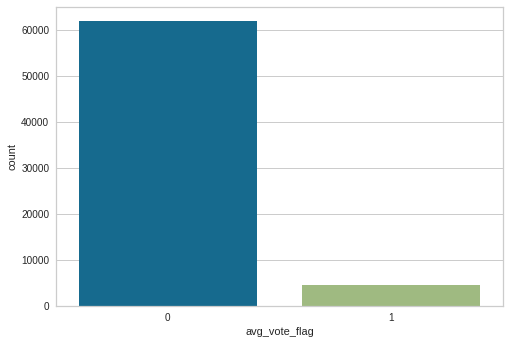

In [9]:
sns.countplot(df_model["avg_vote_flag"])

In [10]:
df_model.isnull().sum().sort_values()

year                                      0
primary_language_Lithuanian               0
primary_language_Lingala                  0
primary_language_Latvian                  0
primary_language_Latin                    0
primary_language_Lao                      0
primary_language_Kurdish                  0
primary_language_Kru                      0
primary_language_Korean                   0
primary_language_Kirghiz                  0
primary_language_Kinyarwanda              0
primary_language_Khmer                    0
primary_language_Kazakh                   0
primary_language_Kashmiri                 0
primary_language_Kannada                  0
primary_language_Kabuverdianu             0
primary_language_Japanese                 0
primary_language_Italian                  0
primary_language_Low German               0
primary_language_Irish                    0
primary_language_Luxembourgish            0
primary_language_Malay                    0
primary_language_Polish         

# Train model
important to not miss the high rating movies

In [ ]:
# regression
parameters = {
    "plot_write_dir": os.path.join(PROJECT_BASE_DIR, plot_write_dir),
    "model_save_dir": os.path.join(PROJECT_BASE_DIR, model_save_dir),
    "model_type": "regression",  # , classification
    "idx_columns": idx_columns,
    "test_set_size": 0.1,
    "training_parameters": {
        "class_weight": "balanced",  # vs providing sample weight to fit --> does it make a difference?
        "n_jobs": -1,
        "max_iter" : 10000,
        "scoring": "balanced_accuracy",
    },
}

reg_model, df_reg_coefs, reg_x_test, reg_y_test = train_model(
    df_model,
    parameters=parameters,  # , load_from_disk="regression_2020_03_02_17_32.joblib"
)

# classification
parameters.update({"model_type": "classification"})
clf_model, df_clf_coefs, clf_x_test, clf_y_test = train_model(
    df_model,
    parameters=parameters,
    # load_from_disk="classification_2020_03_02_17_35.joblib",
)
assert clf_x_test.equals(reg_x_test)
y_test = clf_y_test.join(reg_y_test.drop(columns=idx_columns))
assert len(y_test) == len(reg_x_test)
assert all(y_test.isna().sum() == 0)
assert all(y_test.index == reg_x_test.index)

Diagnostic plots for this model can be found in the following directory: 
/home/rohail/projects/imdb_ratings/reports/figures
The model itself is saved in the following directory: /home/rohail/projects/imdb_ratings/models/

The training took 5.827 seconds 

Diagnostic plots for this model can be found in the following directory: 
/home/rohail/projects/imdb_ratings/reports/figures
The model itself is saved in the following directory: /home/rohail/projects/imdb_ratings/models/



# Validate model

## Compare the two on same examples from test set

In [ ]:
parameters = {
    "target_columns": ["avg_vote", "avg_vote_flag"],
    "classification_threshold": 0.1, # determined from looking at diagnostic plot....
    "regression_threshold": TARGET_CUTOFF,
    "idx_columns": idx_columns,
}

train_movies_sample = {
    "The Dark Knight",
    "Anchorman: The Legend of Ron Burgundy",
    "The Big Lebowski",
    "Batman v Superman: Dawn of Justice",
    "Black Panther",
    "Kabhi Khushi Kabhie Gham...",
    "3 Idiots",
    "The Intouchables",
    "Amélie",
    "The Matrix",
    "The Matrix Reloaded",
    "V for Vendetta",
    "Kill Bill: Vol. 1",
    "La vita è bella",
    "Die Hard",
    "Requiem for a Dream",
    "Terminator 3: Rise of the Machines",
    "The Terminator",
    "Terminator 2: Judgment Day",
    "Titanic",
    "The Departed",
    "Groundhog Day",
    "Love in Kilnerry",
    "Jinnah",
    "Jawani Phir Nahi Ani",
    "Bol",
    "Das letzte Mahl",
    "The Lives of Others",
    "Das Experiment",
}

# predict on unseen examples depending on model type...
df_predict_test, df_predict_train  = compare_methods(
    df_model, reg_model, clf_model, clf_x_test, y_test, train_movies_sample, parameters
)